In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from CosinorPy import file_parser, cosinor, cosinor1

In [39]:
data = pd.read_csv("PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_22960\4115990109.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("PrometneNesreče.csv")


# Kosinor analiza po urah: delovnik vs. vikend

In [40]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

# Dodaj stolpca za uro in dan v tednu
data['hour'] = data['NastanekDatumCas'].dt.hour
data['weekday'] = data['NastanekDatumCas'].dt.weekday

# Razdeli dneve na delovnik in vikend
workdays = data[data['weekday'] < 5]
weekends = data[data['weekday'] >= 5]

# Preštej nesreče po urah za delovnik
accidents_per_hour_workdays = workdays['hour'].value_counts().sort_index()

# Preštej nesreče po urah za vikend
accidents_per_hour_weekend = weekends['hour'].value_counts().sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_workdays = pd.DataFrame({
    "test": "HourlyAccidents_Workdays",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_workdays.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_workdays.values  # Število nesreč za tisto uro
})

df_weekends = pd.DataFrame({
    "test": "HourlyAccidents_Weekends",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_weekend.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_weekend.values  # Število nesreč za tisto uro
})


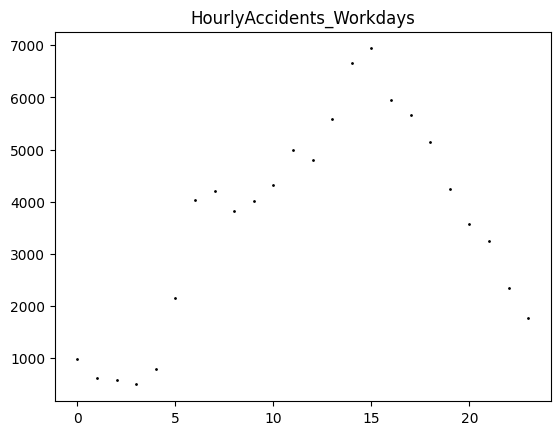

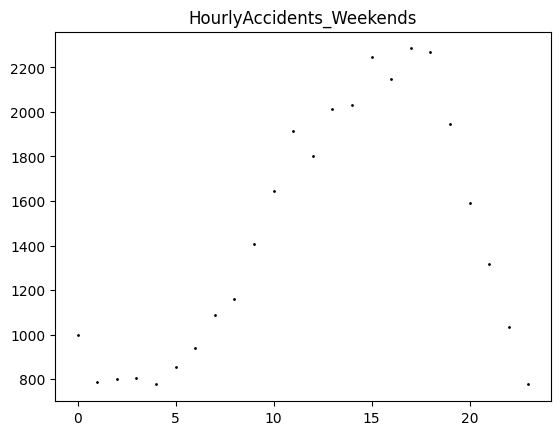

In [41]:
cosinor.plot_data(df_workdays, names = ["HourlyAccidents_Workdays"])
cosinor.plot_data(df_weekends, names = ["HourlyAccidents_Weekends"])

## Periodogram

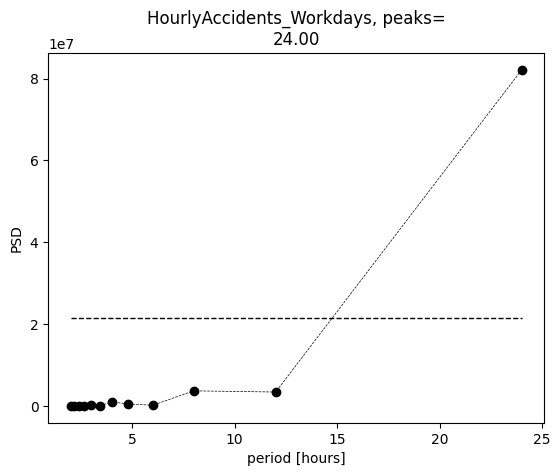

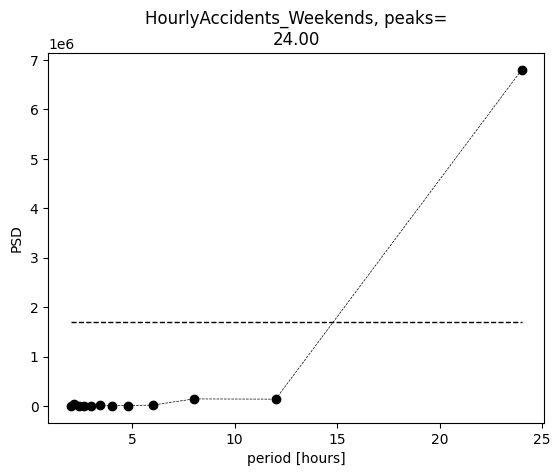

In [42]:
cosinor.periodogram_df(df_workdays)
cosinor.periodogram_df(df_weekends)

## Iskanje najboljšega modela

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


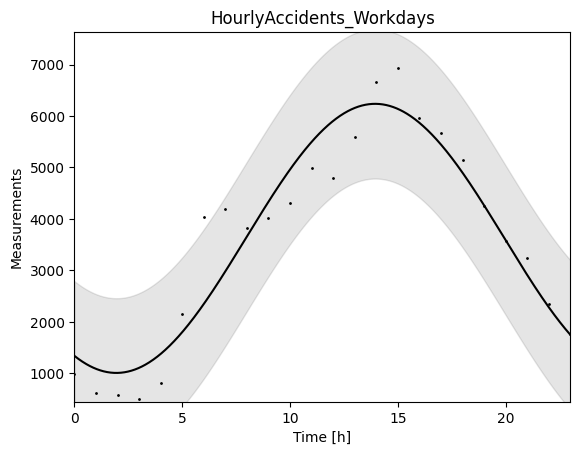

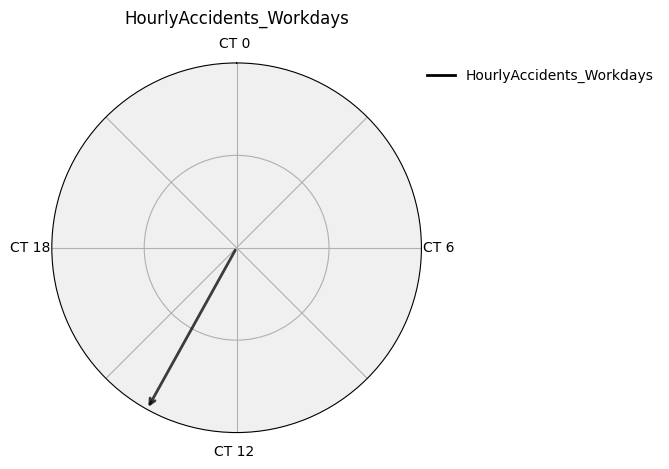

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


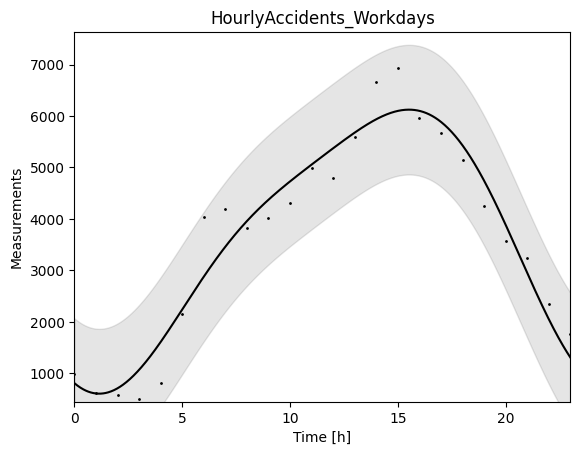

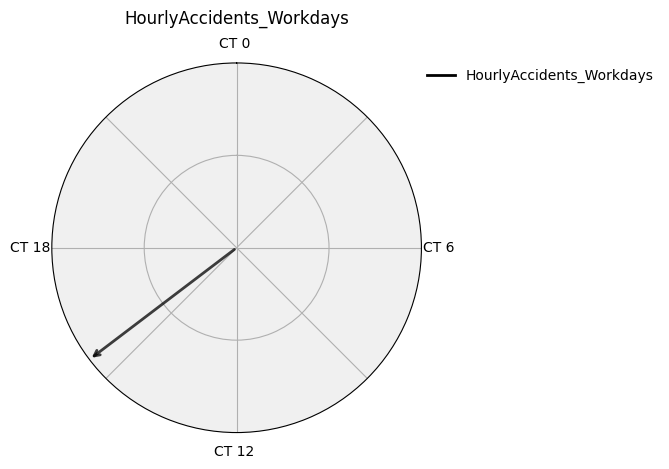

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


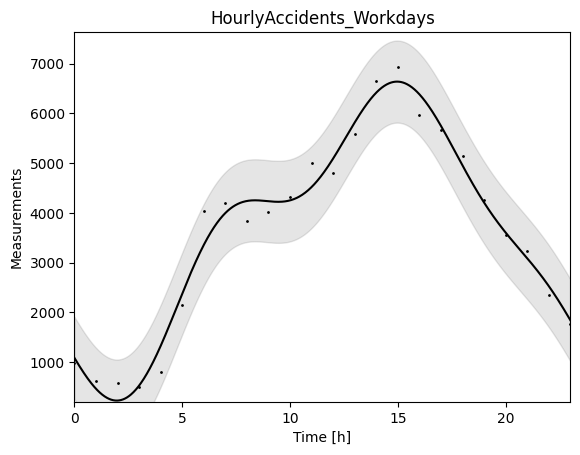

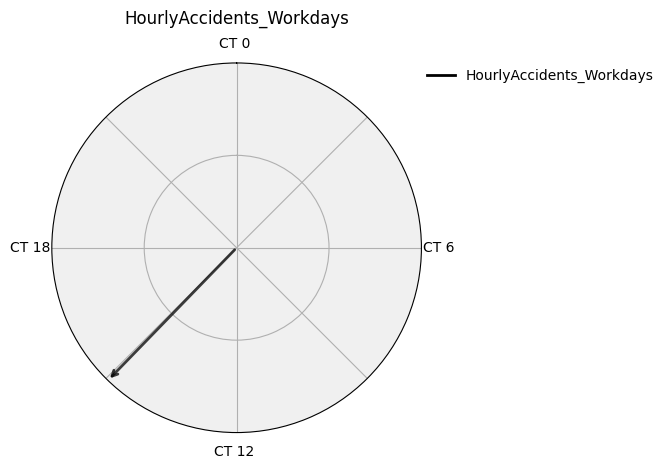

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


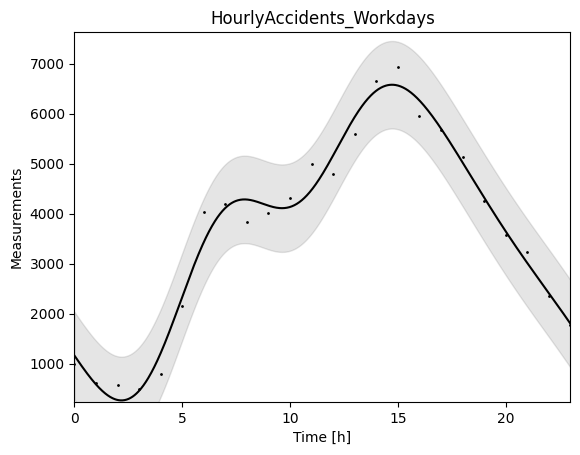

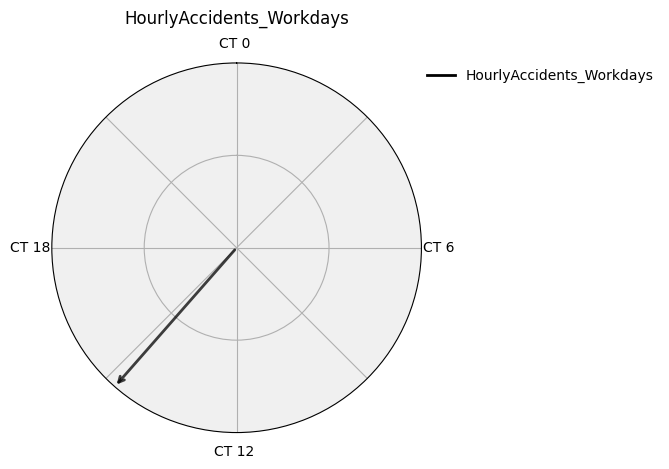

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


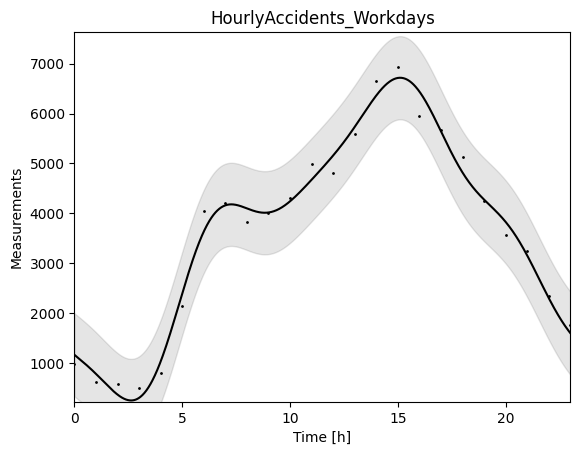

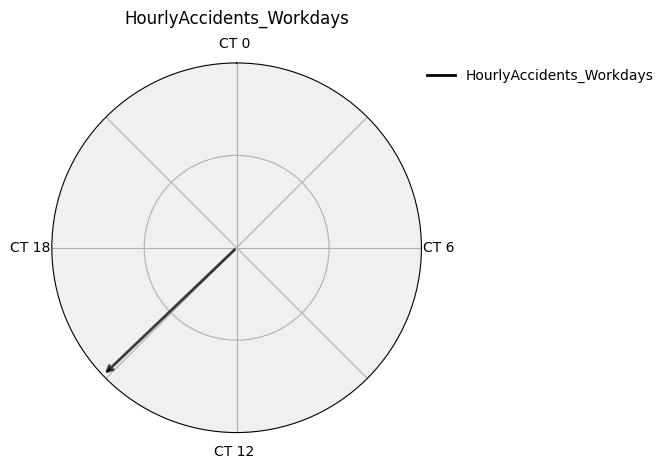

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


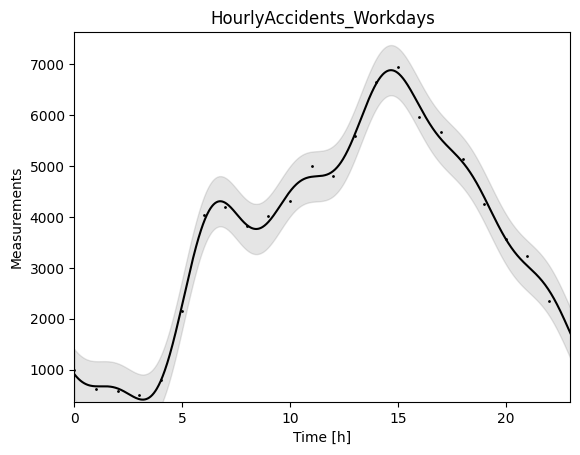

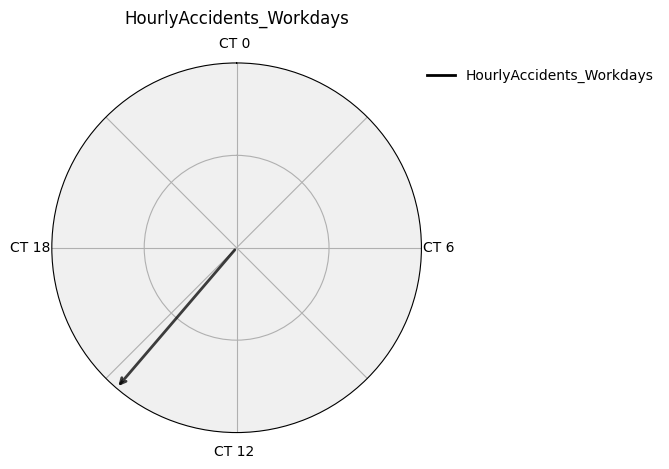

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


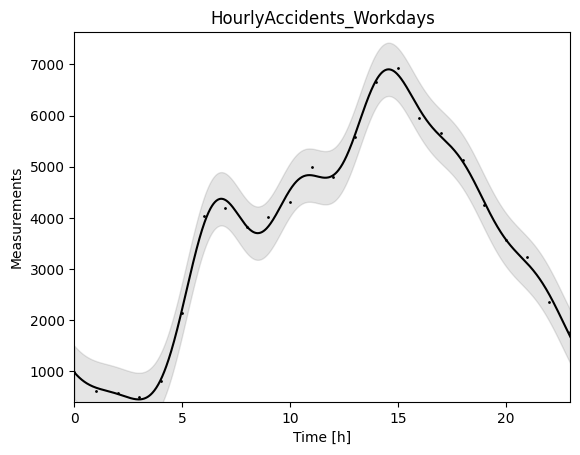

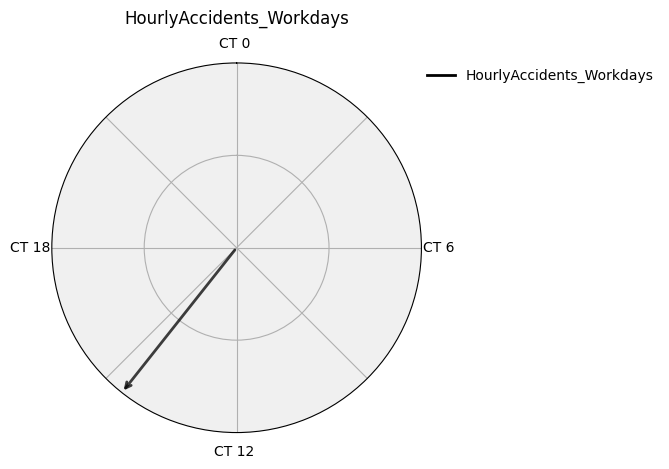

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


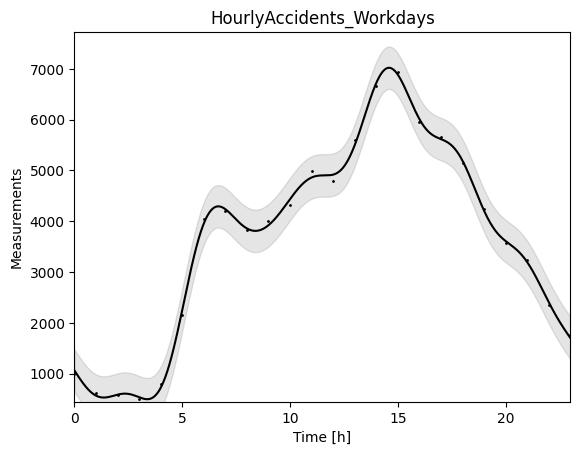

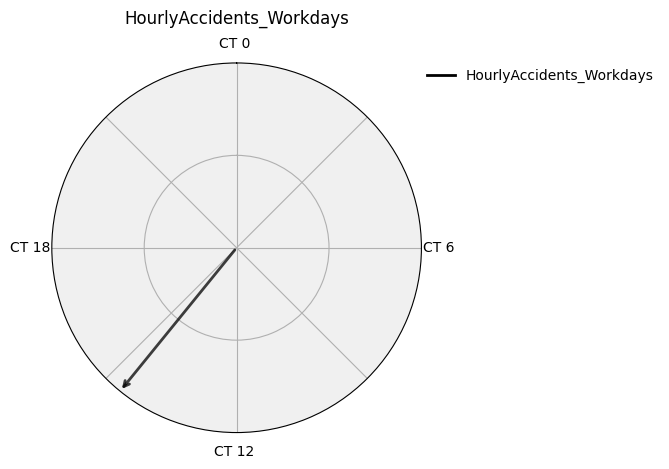

In [51]:
# DELOVNIK: Poskusim modele z različnim številom komponent
df_results_workdays = cosinor.fit_group(df_workdays, n_components = [1,2,3,4,5,6,7,8], period = 24)
#print(df_results_workdays)

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


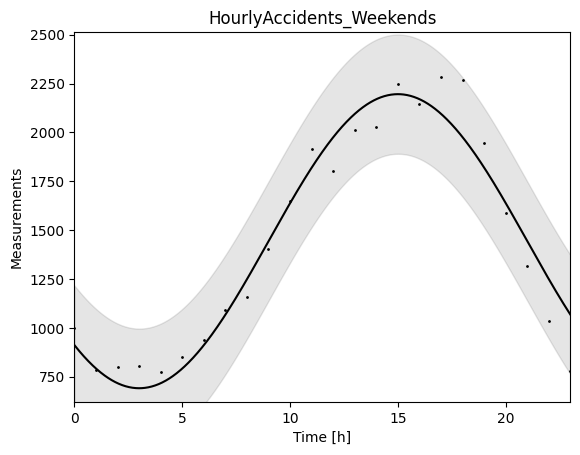

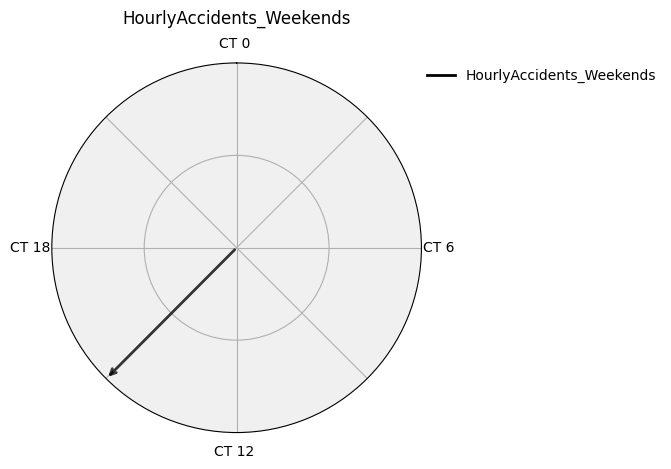

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


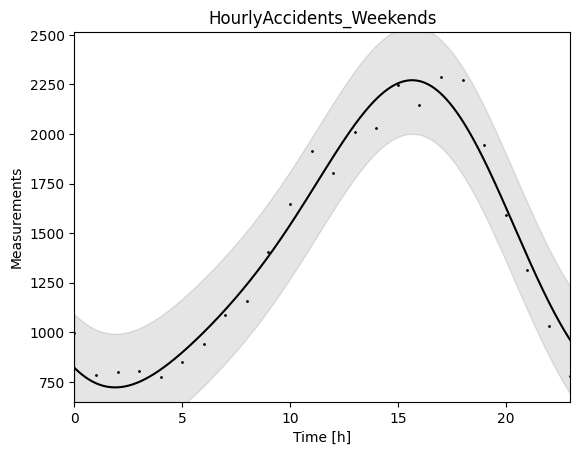

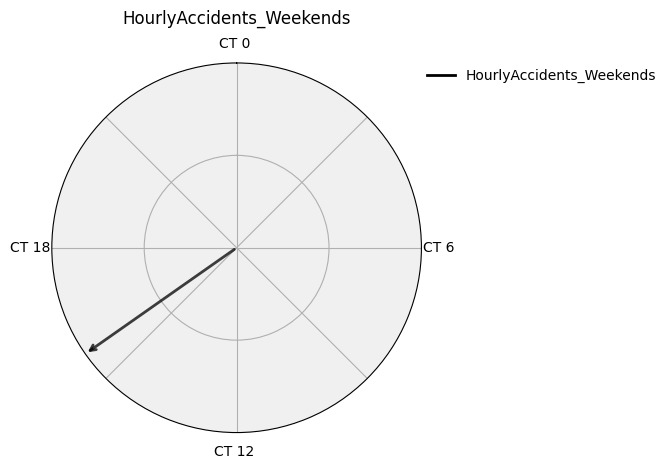

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


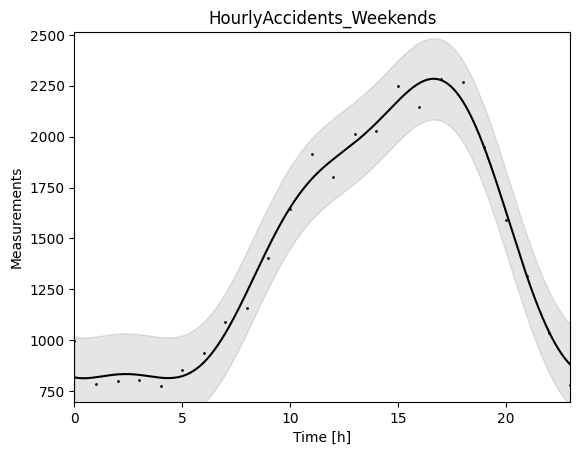

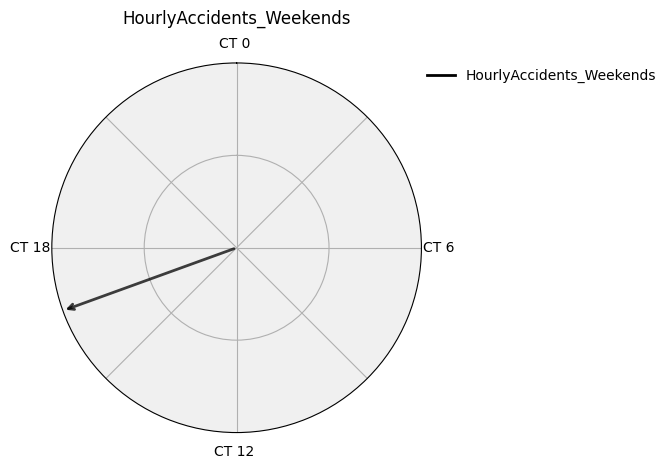

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


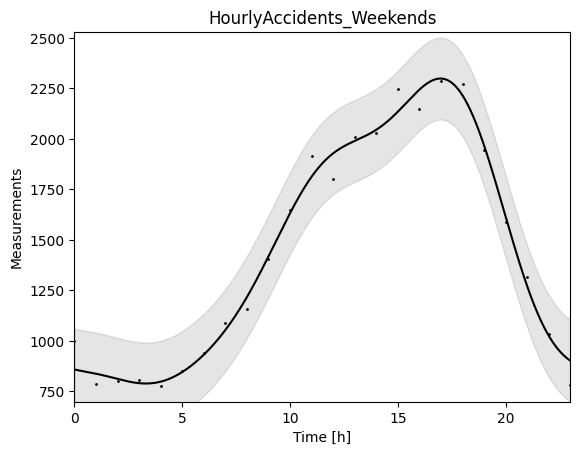

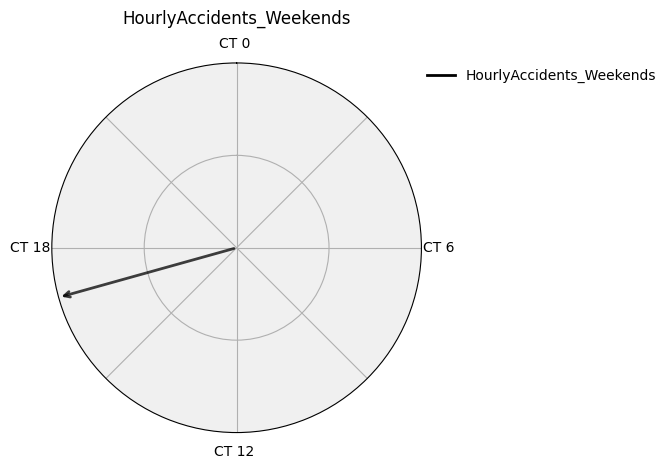

In [52]:
# VIKEND: Poskusim modele z različnim številom komponent
df_results_weekends = cosinor.fit_group(df_weekends, n_components = [1,2,3,4], period = 24)

## Najboljša modela

In [53]:
df_best_model_workdays = cosinor.get_best_models(df_workdays, df_results_workdays, n_components = [1,2,3,4,5,6,7,8])
df_best_model_workdays

,test,period,n_components,p,q,p_reject,q_reject,RSS,R2,R2_adj,log-likelihood,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,ME,resid_SE
0,HourlyAccidents_Workdays,24.0,6.0,2.019040e-11,5.766552e-11,NaN,NaN,359375.880338,0.99606,0.991762,-149.423369,3237.325336,2.434027,3646.855583,"[6.774774774774775, 14.702702702702702]","[4308.399623810055, 6883.8892079961015]","[1.105105105105105, 3.171171171171171]","[670.4266998615004, 409.53024708591715]",397.827898,180.749923


In [54]:
df_best_model_weekends = cosinor.get_best_models(df_weekends, df_results_weekends, n_components = [1,2,3,4])
df_best_model_weekends

,test,period,n_components,p,q,p_reject,q_reject,RSS,R2,R2_adj,log-likelihood,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,ME,resid_SE
0,HourlyAccidents_Weekends,24.0,3.0,3.286260e-14,1.314504e-13,NaN,NaN,118209.039754,0.983577,0.97778,-136.080397,735.358242,1.91829,1549.02162,[16.67267267267267],[2284.3769877591008],"[0.43243243243243246, 4.324324324324325]","[813.6633786619977, 814.4765462358232]",175.932218,83.387487


**Vprašanje:** 
- Delovnik: Če sem nastavila `n_components = [1,2,3,4]`, je bil najboljši model s 3 komponentami. Če pa nastavim `n_components = [1,2,3,4,5,6,7,8]`, je pa najboljši model s 6 komponentami.
- Vikend: Ne glede na to ali sem poskusila z `[1,2,3,4]` ali z `[1,2,3,4,5,6,7,8]`, je bil najboljši model s 3 komponentami.

Ali bi morala poskusiti še za večje število komponent? Kako vem, da sem našla globalni maksimum in ne samo lokalnega?

### Delovnik

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


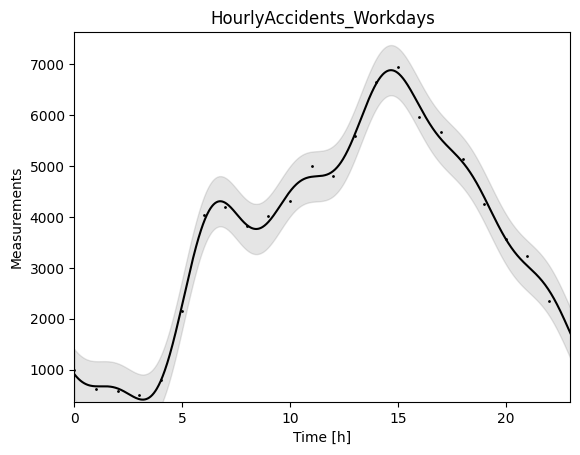

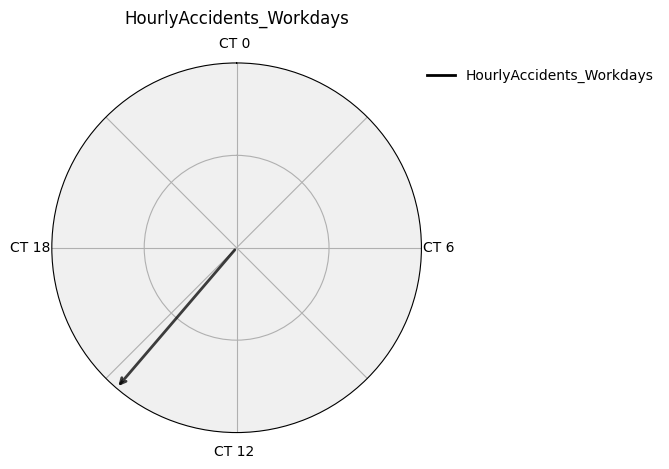

In [47]:
cosinor.plot_df_models(df_workdays, df_best_model_workdays)


### Vikend

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


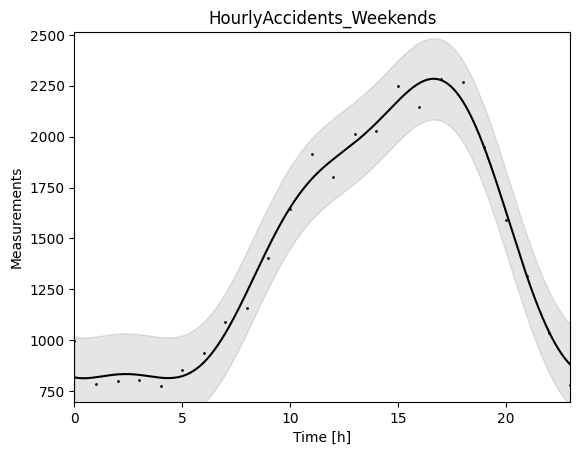

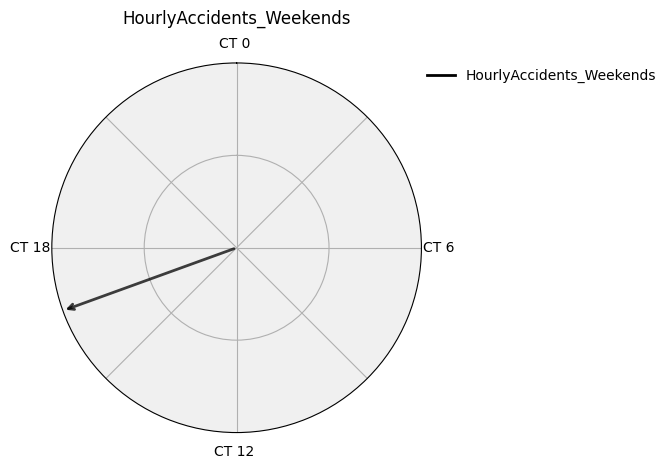

In [48]:
cosinor.plot_df_models(df_weekends, df_best_model_weekends)